In [35]:
## IMPORT 

import os
import numpy as  np
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize
from scipy.signal import resample
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import h5py as h5
import h5py
from pathlib import Path
import matplotlib as mpl

In [36]:
# Text   
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 20
mpl.rcParams['font.family'] = '.SF Camera'

# Boxes
mpl.rcParams['axes.spines.top']= False
mpl.rcParams['axes.spines.right']= False

# plt.rcParams['figure.figsize'] = [4, 5]
plt.rcParams['figure.dpi'] = 140

In [37]:
## LOADING THE MF HDF5 File 

mouse=1028
s='M'


filename=f'{mouse}_{s}_.doric'
folder = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/raw'
h5file = os.path.join(folder, filename)

## LOADING ANYMAZE FILE FOR TTL

TTL_an=pd.read_csv(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/am/{mouse}_sam.csv')
pd.DataFrame(TTL_an)

## LOADING ANYMAZE POSITION FILE 

ampos=pd.read_csv(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/ampos/{mouse}_sam.csv')
pd.DataFrame(ampos)
# Extract ID, sex and stage of experiment

base_name = os.path.basename(filename)
name_parts = base_name.split('_')
mouse_id = name_parts[0]
sex = name_parts[1]



with h5py.File(h5file, 'r') as f:
    # Find the channel signal from DORIC file
    folder = f['DataAcquisition']['EPConsole']['Signals']['Series0001']
    
    # Get time
    raw_time = folder['AIN01xAOUT01-LockIn']['Time']
    

    # Get signal
    values_gcamp = folder['AIN01xAOUT01-LockIn']['Values']
    values_iso = folder['AIN01xAOUT02-LockIn']['Values']
    values_rcamp = folder['AIN02xAOUT03-LockIn']['Values']

    #Get TLL 
    raw_dio_time = folder['DigitalIO']['Time']
    raw_TTL_wn = folder['DigitalIO']['DIO02']
    raw_TTL_tone = folder['DigitalIO']['DIO03']


    #Read the data 
    raw_time = raw_time[:]
    values_gcamp = values_gcamp[:]
    values_iso =  values_iso[:]
    values_rcamp = values_rcamp[:]
    raw_TTL_wn = raw_TTL_wn[:]
    raw_TTL_tone = raw_TTL_tone[:]
    raw_dio_time = raw_dio_time[:]

    #Sanity check for the win
    print("Raw Time (first 5):", raw_time[:5])
    print("Values gcamp (first 5):", values_gcamp[:5])
    print("values rcamp (first 5)", values_rcamp[:5])
    print("Values iso (first 5):", values_iso[:5])
    print("raw dio time (first 5)", raw_dio_time[:5])
    print("TTL_wn:", raw_TTL_wn[:5])
    print(len(values_gcamp))
    print(len(raw_TTL_tone))


Raw Time (first 5): [0.085739 0.102338 0.118939 0.135539 0.152139]
Values gcamp (first 5): [0.08058138 0.08030277 0.08016956 0.0799     0.07958921]
values rcamp (first 5) [1.54363829e-04 2.15651855e-04 2.30263723e-04 2.19027256e-04
 9.98755252e-05]
Values iso (first 5): [0.09618208 0.09593957 0.09575478 0.09565212 0.09544235]
raw dio time (first 5) [0.008632 0.025232 0.041832 0.058432 0.075031]
TTL_wn: [0. 0. 0. 0. 0.]
36137
36151


Average Sampling Interval: 0.0166 seconds
Sampling Frequency: 60.24096385542168 Hz
duration:, 599.8576 seconds
Average Sampling Interval after resampling: 0.016672328545232273 seconds
Sampling Frequency after resampling: 59.97962415909603 Hz
(35992,)
(35992,)
(35992,)
599.943339
600.098632


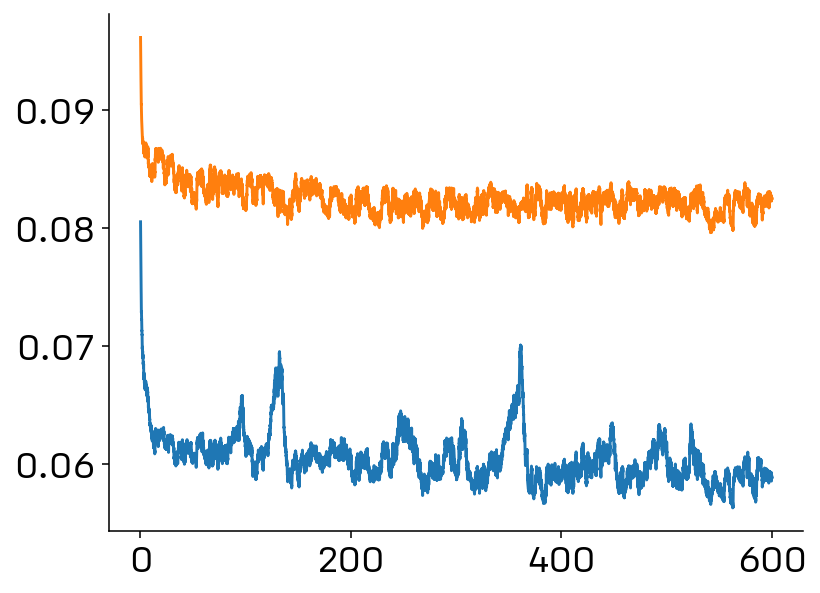

In [38]:
#RESAMPLING 
##Check the sampling 

# Calculate the differences between consecutive time points
time_differences = np.diff(raw_time)
average_sampling_interval = np.mean(time_differences)

# Calculate the sampling frequency
sampling_frequency = 1 / average_sampling_interval

print(f"Average Sampling Interval: {average_sampling_interval} seconds")
print(f"Sampling Frequency: {sampling_frequency} Hz")


### RESAMPLING 
duration = raw_time[-1] - raw_time[0]

new_sampling_rate = 60  # Hz
num_samples_resampled = int(duration * new_sampling_rate) + 1 ##Integer because can't be a fraction

# Resample gcamp + iso + TTL 
resampled_gcamp, time = resample(values_gcamp, num_samples_resampled, t=raw_time)
resampled_rcamp, time = resample(values_rcamp, num_samples_resampled, t=raw_time)
resampled_iso, time = resample(values_iso, num_samples_resampled, t=raw_time)
resampled_TTL_wn, time = resample(raw_TTL_wn, num_samples_resampled, t=raw_time) ##CAREFUL USING THIS, TTL TIME IS HERE CONSIDERED AS GCAMP TIME, IT'S AN APPROXIMATION, ALWAYS CHECK IF MAKES SENSE
resampled_TTL_tone, time = resample(raw_TTL_tone, num_samples_resampled, t=raw_time) ##CAREFUL USING THIS, TTL TIME IS HERE CONSIDERED AS GCAMP TIME, IT'S AN APPROXIMATION, ALWAYS CHECK IF MAKES SENSE

print(f"duration:, {duration} seconds")

## Sanity check for the win 
time_differences_resampled = np.diff(time)
average_sampling_interval_resampled = np.mean(time_differences_resampled)
sampling_frequency_resampled = 1 / average_sampling_interval_resampled

print(f"Average Sampling Interval after resampling: {average_sampling_interval_resampled} seconds")
print(f"Sampling Frequency after resampling: {sampling_frequency_resampled} Hz")
print(resampled_gcamp.shape)
print(resampled_rcamp.shape)
print(resampled_TTL_wn.shape)
print(raw_time[-1])
print(raw_dio_time[-1])

plt.plot(time, resampled_gcamp)
plt.plot(time, resampled_iso)

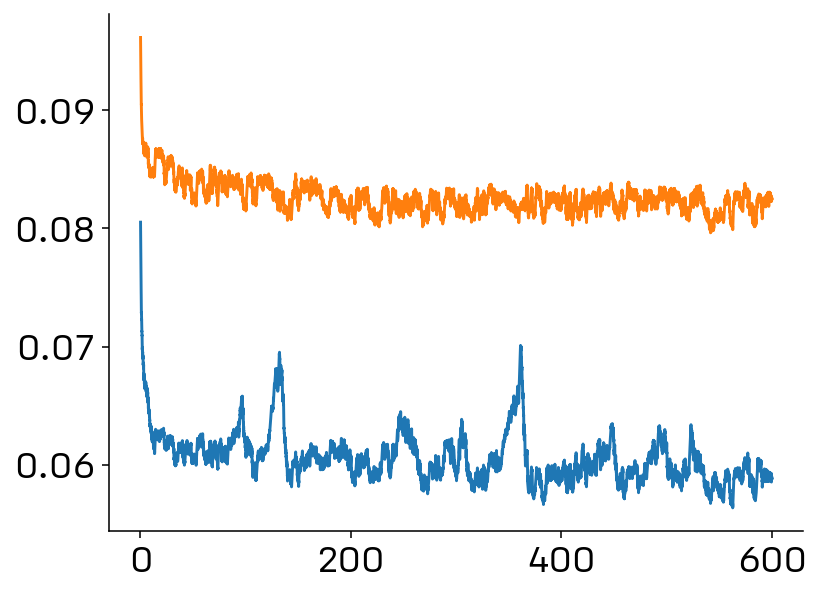

In [39]:
###Removing artifacts 

import numpy as np
from scipy.interpolate import interp1d

def remove_artifacts_and_interpolate(signal, time, threshold=0.0005, time_window=0.5):
    # Create a copy of the original signal
    cleaned_signal = signal.copy()

    # Define the sliding window size based on the time window
    window_size = np.sum(time <= time_window)

    # Iterate through the signal using a sliding window
    for i in range(len(cleaned_signal) - window_size):
        # Calculate the difference in signal within the window
        window_diff = cleaned_signal[i + window_size] - cleaned_signal[i]

        # If the difference exceeds the threshold, mark it as NaN
        if window_diff > threshold:
            cleaned_signal[i:i + window_size] = np.nan

    # Interpolate the NaN values
    nan_indices = np.isnan(cleaned_signal)
    interpolator = interp1d(time[~nan_indices], cleaned_signal[~nan_indices], kind='linear', fill_value='extrapolate')
    cleaned_signal[nan_indices] = interpolator(time[nan_indices])

    return cleaned_signal

# Apply the function to both 'resampled_gcamp' and 'resampled_iso'
resampled_gcamp = remove_artifacts_and_interpolate(resampled_gcamp, time)
resampled_iso = remove_artifacts_and_interpolate(resampled_iso, time)
resampled_rcamp = remove_artifacts_and_interpolate(resampled_rcamp, time)

# 'resampled_gcamp' and 'resampled_iso' now contain the cleaned signals


plt.plot(time, resampled_gcamp)
plt.plot(time, resampled_iso)

In [40]:
# ####ABBERRANCE DETECTION : WHEN SIGNAL FUCKS UP - PATCHCORD gets detached

# # Calculate the first derivative of the signal
# signal_diff = np.diff(resampled_gcamp, prepend=resampled_gcamp[0])

# # Set a threshold for detecting large jumps in the signal
# threshold = np.std(signal_diff) * 20  # Adjust the factor as needed

# # Identify the indices where the signal changes significantly
# power_change_indices = np.where(np.abs(signal_diff) > threshold)[0]

# print("Detected power change points at indices:", power_change_indices)

In [41]:
# #CORRECT THE ABBERATION

# # Your resampled_gcamp signal and detected power change indices
# # resampled_gcamp is your signal array
# # power_change_indices contains the indices where signal changes (detected earlier)
# # Include the start and end of the signal in the indices
# power_change_indices = np.concatenate(([0], power_change_indices, [len(resampled_gcamp)]))

# # Initialize an array to store the corrected signal
# corrected_signal = np.copy(resampled_gcamp)

# # Scale each segment based on the mean of the first segment
# base_mean = np.mean(resampled_gcamp[power_change_indices[0]:power_change_indices[1]])

# # Loop over each segment and scale them
# for i in range(len(power_change_indices) - 1):
#     start_idx = power_change_indices[i]
#     end_idx = power_change_indices[i + 1]

#     # Calculate the mean of the current segment
#     segment_mean = np.mean(resampled_gcamp[start_idx:end_idx])

#     # Compute the scaling factor
#     scaling_factor = base_mean / segment_mean

#     # Scale the segment
#     corrected_signal[start_idx:end_idx] *= scaling_factor

# # Now corrected_signal contains the adjusted signal
# print("Signal successfully scaled across segments!")

# plt.figure(figsize=(10,6))
# plt.plot(time, resampled_gcamp, label='Original Signal', alpha=0.6)
# plt.plot(time, corrected_signal, label='Corrected Signal', alpha=0.8)
# plt.legend()
# plt.title('Original vs Corrected Signal')
# plt.show()

# len(resampled_gcamp)
# # len(corrected_signal)


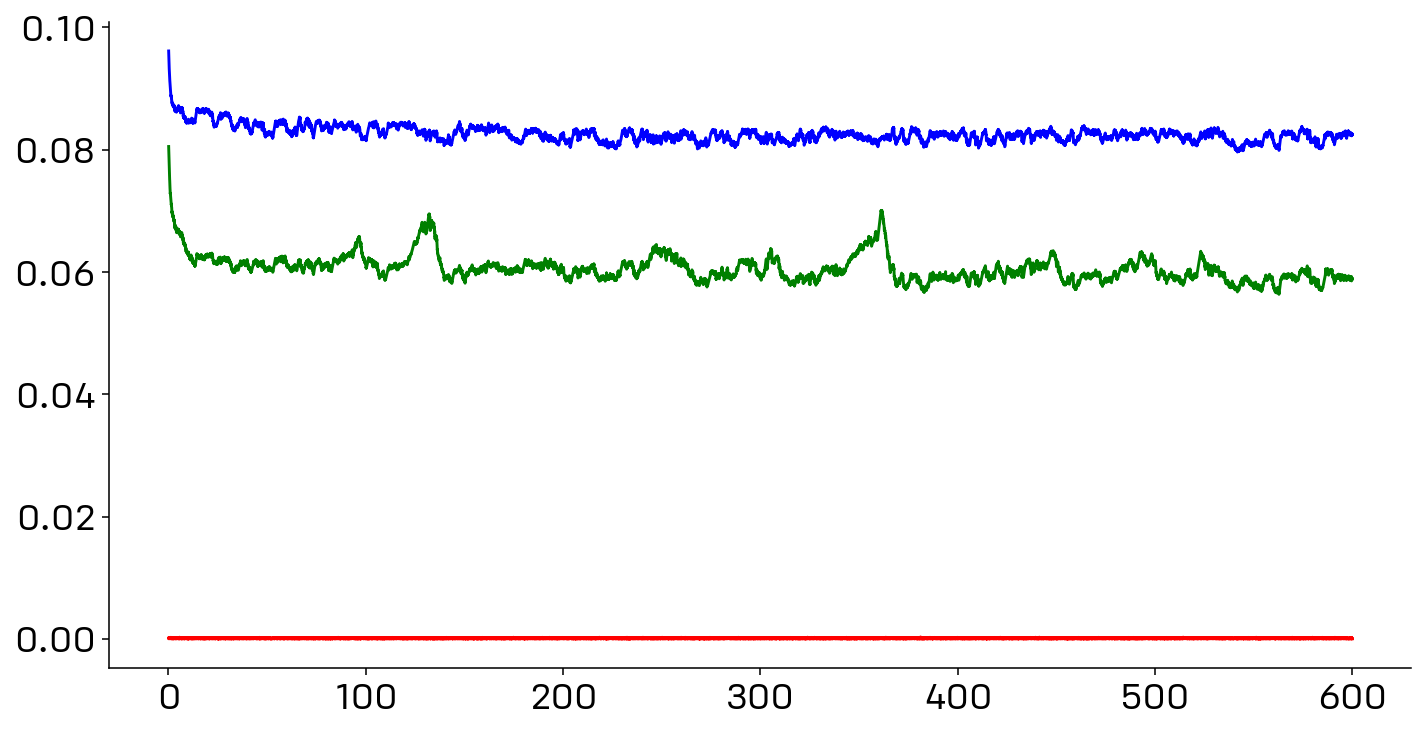

In [42]:

##RAW SIGNAL PLOT

# fig,ax1=plt.subplots(figsize=(12,6))  # create a plot to allow for dual y-axes plotting
# plot1=ax1.plot(time, resampled_gcamp, 'g', label='gcamp') 
# ax2=plt.twinx()# create a right y-axis, sharing x-axis on the same plot
# plot2=ax2.plot(time, resampled_iso, 'r', label='isosbestic') 
# # Labels
# lines = plot1 + plot2
# labels = [l.get_label() for l in lines]  
# legend = ax1.legend(lines, labels) 

# ax1.set_ylim(0.3, 0.8)
# ax2.set_ylim(0.3, 0.8)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time, resampled_gcamp, color='g', label='Smoothed FP Zscore (Savitzky-Golay)')
plt.plot(time, resampled_iso, color='b')
plt.plot(time, resampled_rcamp, color='r')

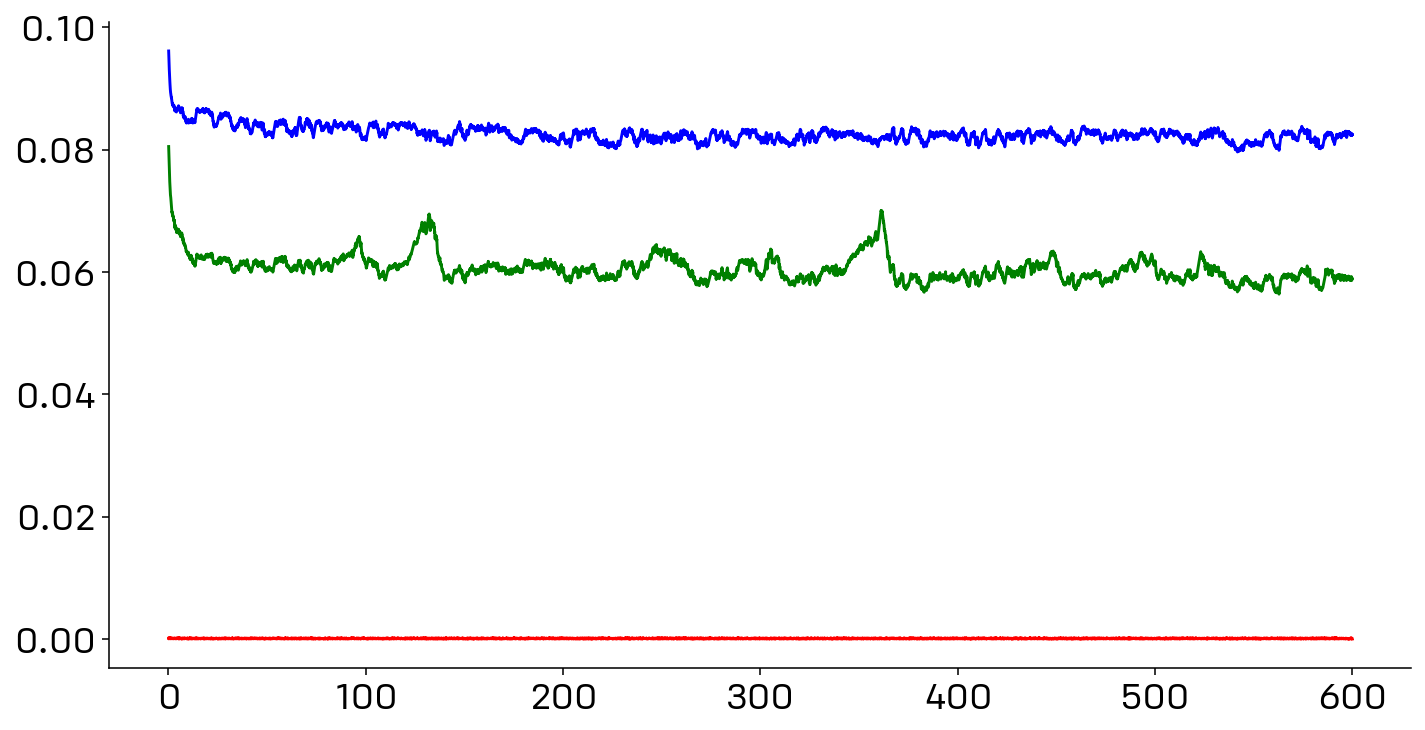

In [43]:
## NOISE CORRECTION 
sampling_rate = 60

b,a = butter(2, 10, btype='low', fs=sampling_rate)
gcamp_denoised = filtfilt(b,a, resampled_gcamp)
iso_denoised = filtfilt(b,a, resampled_iso)
rcamp_denoised = filtfilt(b, a, resampled_rcamp)


##NOISE CORRECTION  PLOT
plt.figure(figsize=(12, 6))
plt.plot(time, gcamp_denoised, color='g', label='Smoothed FP Zscore (Savitzky-Golay)')
plt.plot(time, iso_denoised, color='b')
plt.plot(time, rcamp_denoised, color='r')
#ax2.set_ylim(0.6, 1.2)

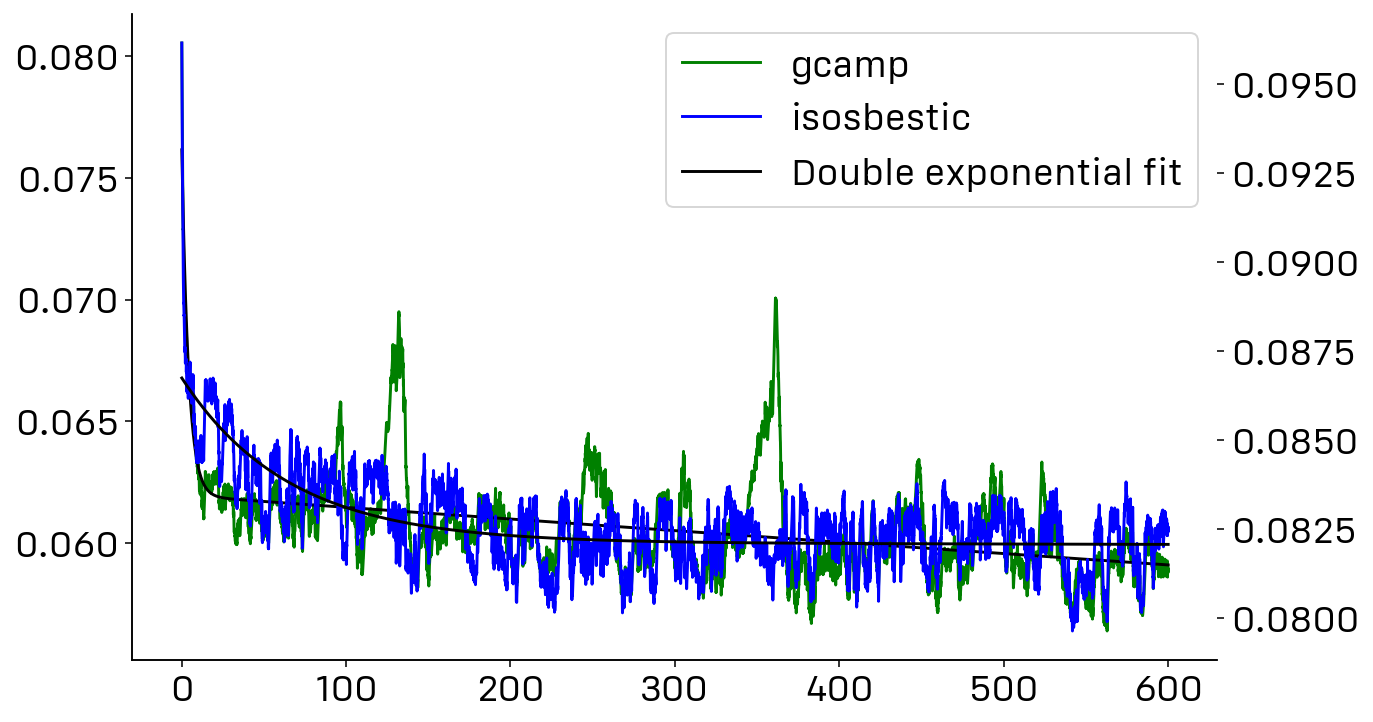

In [44]:
## PHOTOBLEACHING CORRECTION -> Maybe fit only on baseline periods and apply it to everything? 
#Using double exponential fit  

def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):

    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)

## Fitting exp to signal 
#Gcamp
max_sig = np.max(gcamp_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
gcamp_params, parm_cov = curve_fit(double_exponential, time, gcamp_denoised, ## TO APPLY IT ON BASELINE, SET A BASELINE_TIME
                                  p0=inital_params, bounds=bounds, maxfev=1000) ##maxfev = number of iterations for least squares optimization
gcamp_expfit = double_exponential(time, *gcamp_params)

#Isosbestic
max_sig = np.max(iso_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
iso_params, parm_cov = curve_fit(double_exponential, time, iso_denoised, ## TO APPLY IT ON BASELINE, SET A BASELINE_TIME
                                  p0=inital_params, bounds=bounds, maxfev=1000) ##maxfev = number of iterations for least squares 
iso_expfit = double_exponential(time, *iso_params)

#Rcamp
max_sig = np.max(rcamp_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
rcamp_params, parm_cov = curve_fit(double_exponential, time, rcamp_denoised, ## TO APPLY IT ON BASELINE, SET A BASELINE_TIME
                                  p0=inital_params, bounds=bounds, maxfev=1000) ##maxfev = number of iterations for least squares 
rcamp_expfit = double_exponential(time, *rcamp_params)

##PLOTS 

fig,ax1=plt.subplots(figsize=(10,6))  

plot1=ax1.plot(time, gcamp_denoised, 'g', label='gcamp')
plot3=ax1.plot(time, gcamp_expfit, color='k', linewidth=1.5, label='Double exponential fit') 
ax2=plt.twinx()
plot2=ax2.plot(time, iso_denoised, color='b', label='isosbestic') 
plot4=ax2.plot(time, iso_expfit,color='k', linewidth=1.5) 

lines = plot1 + plot2 + plot3
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels); 


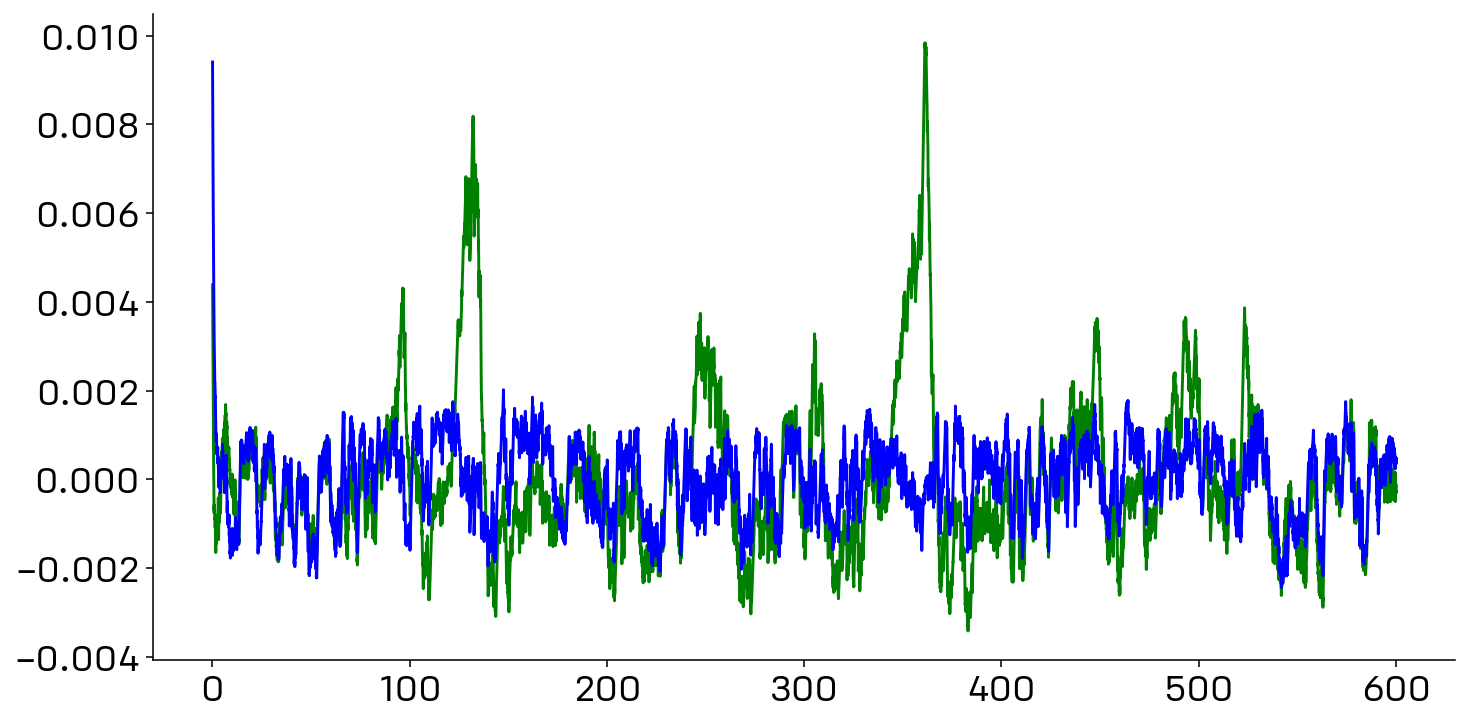

In [45]:
##PHOTOBLEACHING FREE PLOT
gcamp_detrended = gcamp_denoised - gcamp_expfit
iso_detrended = iso_denoised - iso_expfit
rcamp_detrended = rcamp_denoised - rcamp_expfit

plt.figure(figsize=(12, 6))
plt.plot(time, gcamp_detrended, color='g')
plt.plot(time, iso_detrended, color='b')



(0.0, 5.0)

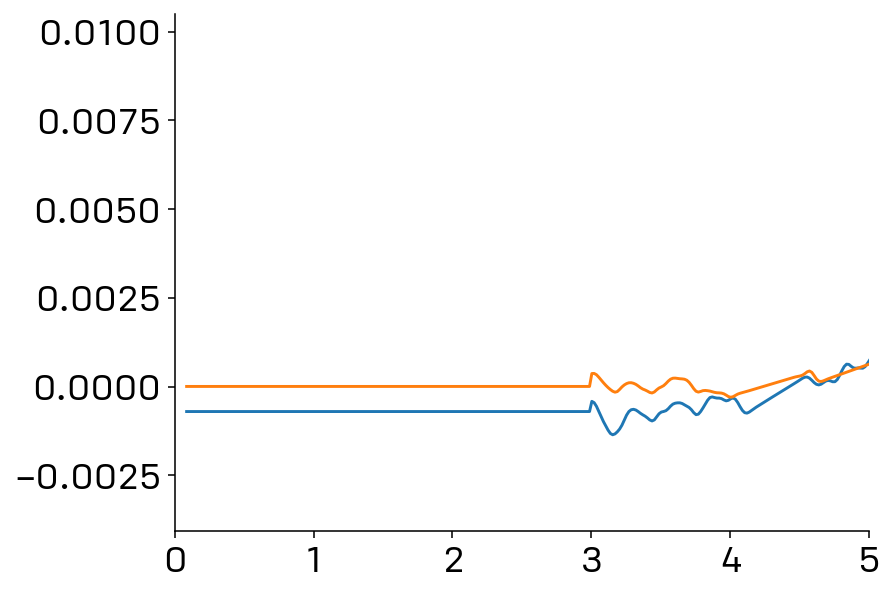

In [46]:
##WHEN TOO MUCH SIGNAL, just take out the first 3 seconds to not fuck up dff
# Find indices for the 3rd second (from 2 to 3 seconds)
indices_3_sec = (time >= 3) & (time < 4)

# Calculate the average values in the 3rd second
gcamp_3_sec_avg = np.mean(gcamp_detrended[indices_3_sec])
iso_3_sec_avg = np.mean(iso_detrended[indices_3_sec])
rcamp_3_sec_avg = np.mean(rcamp_detrended[indices_3_sec])

# Find the indices for the first 2 seconds
indices_2_sec = time < 3

# Set the first 2 seconds to the 3-second average value
gcamp_detrended[indices_2_sec] = gcamp_3_sec_avg
iso_detrended[indices_2_sec] = iso_3_sec_avg
rcamp_detrended[indices_2_sec] = rcamp_3_sec_avg

# Plot results

plt.plot(time, gcamp_detrended)
plt.plot(time, iso_detrended)
plt.xlim(0,5)



Slope    : 0.683
R-squared: 0.105


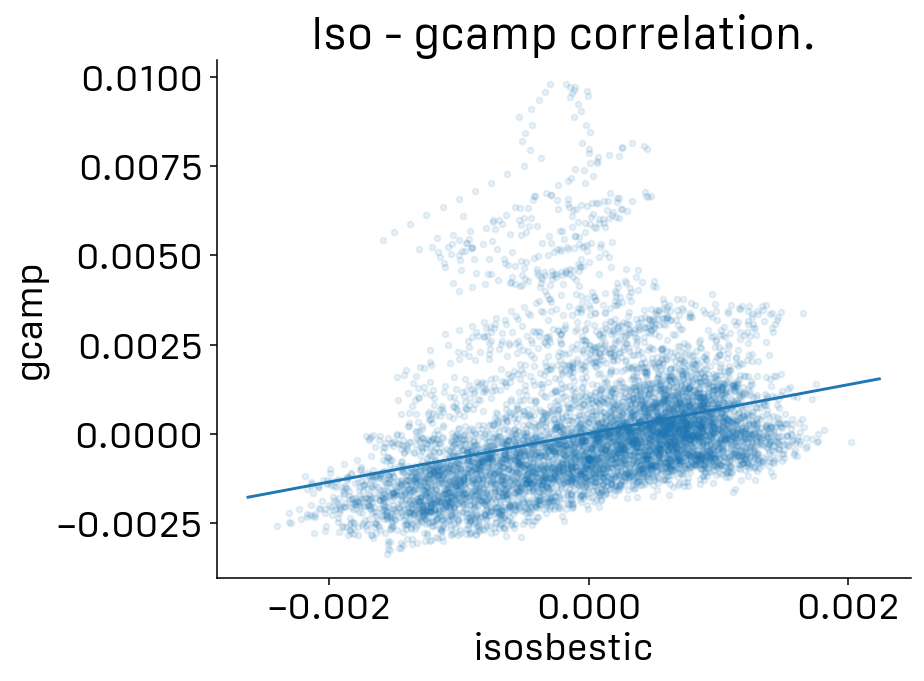

In [47]:
##REMOVING MOVEMENT ARTIFACTS 
##Using linear regression to fit iso to gcamp

slope, intercept, r_value, p_value, std_err = linregress(x=iso_detrended, y=gcamp_detrended) #get regression parameters 

plt.scatter(iso_detrended[::5], gcamp_detrended[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x) #Plot the regression line 
plt.xlabel('isosbestic')
plt.ylabel('gcamp')
plt.title('Iso - gcamp correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))


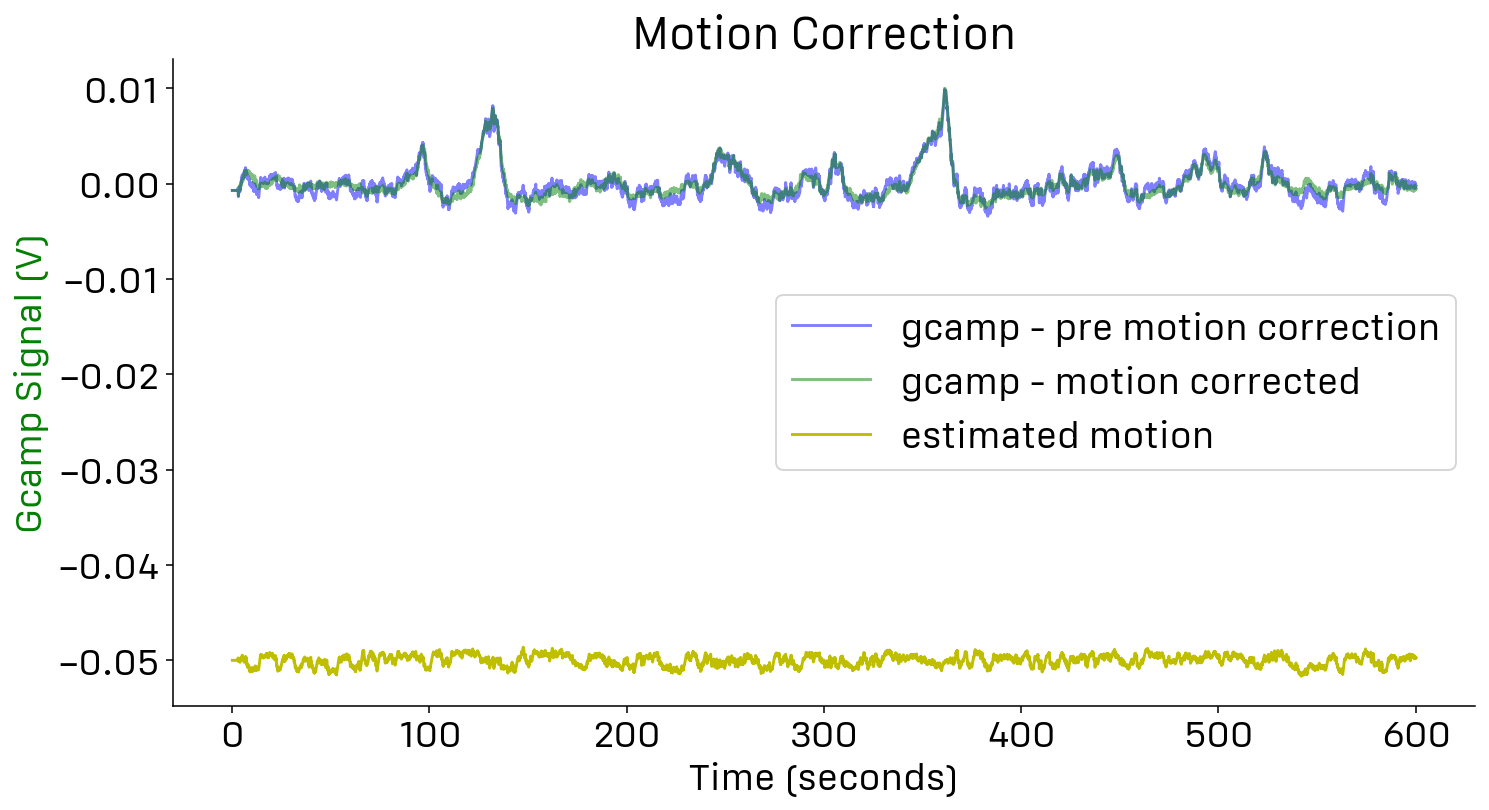

In [48]:
##SUBSTRACTING ESTIMATED MOTION 

gcamp_est_motion = intercept + slope * iso_detrended
gcamp_corrected = gcamp_detrended - gcamp_est_motion

fig,ax1=plt.subplots(figsize=(12,6))  
plot1=ax1.plot(time, gcamp_detrended, 'b' , label='gcamp - pre motion correction', alpha=0.5)
plot3=ax1.plot(time, gcamp_corrected, 'g', label='gcamp - motion corrected', alpha=0.5)
plot4=ax1.plot(time, gcamp_est_motion - 0.05, 'y', label='estimated motion')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Gcamp Signal (V)', color='g')
ax1.set_title('Motion Correction')

lines = plot1+plot3+plot4
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels)

#ax1.set_xlim(0, 460)  # 60 sec window
#ax1.set_ylim(-0.075, 0.1)

Slope    : -0.000
R-squared: 0.000


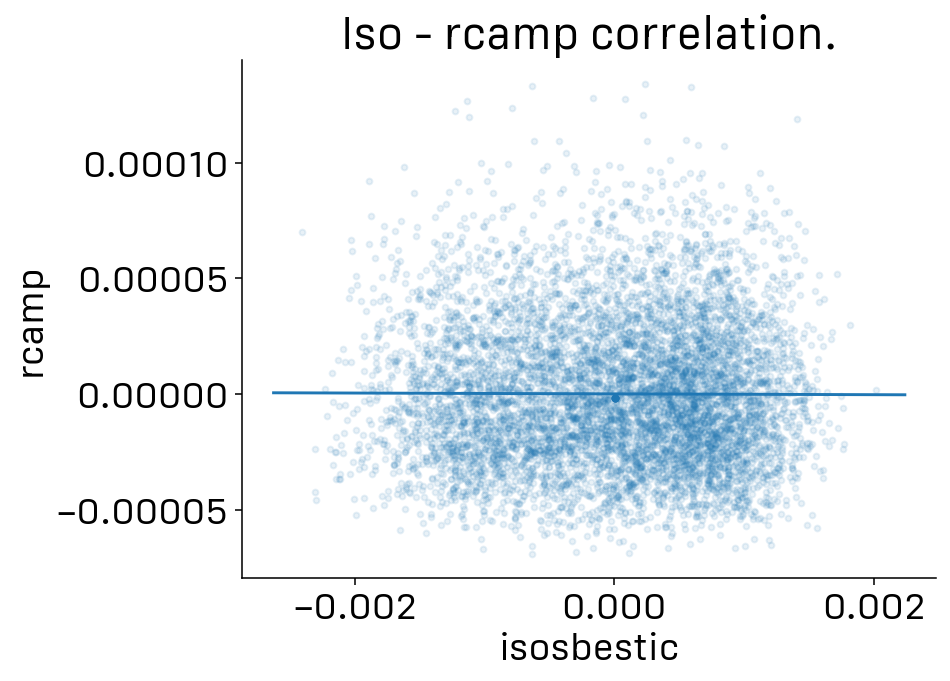

In [49]:
##REMOVING MOVEMENT ARTIFACTS RCAMP 
##Using linear regression to fit iso to gcamp

slope, intercept, r_value, p_value, std_err = linregress(x=iso_detrended, y=rcamp_detrended) #get regression parameters 

plt.scatter(iso_detrended[::5], rcamp_detrended[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x) #Plot the regression line 
plt.xlabel('isosbestic')
plt.ylabel('rcamp')
plt.title('Iso - rcamp correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))


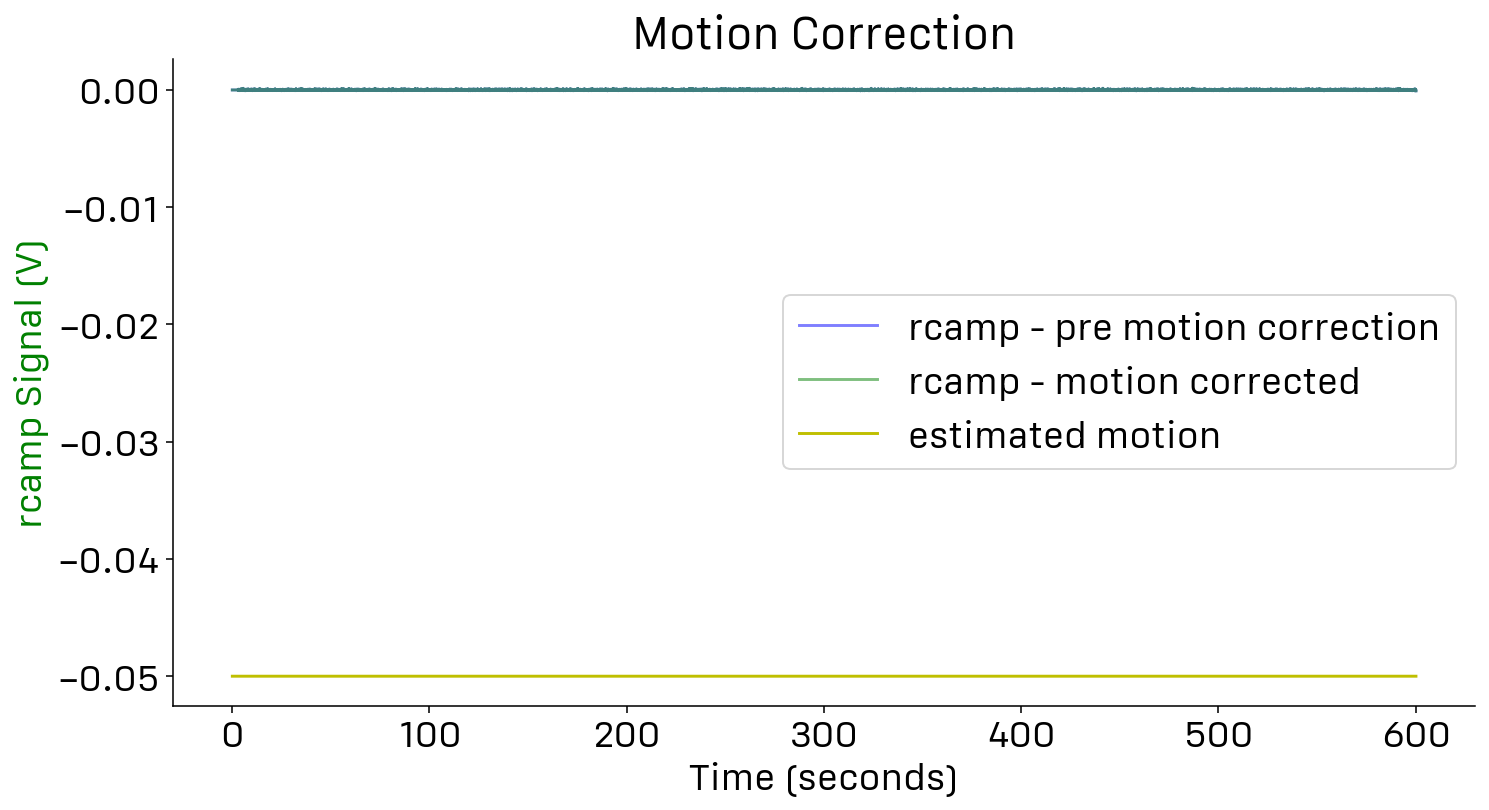

In [50]:
##SUBSTRACTING ESTIMATED MOTION RCAMP 

rcamp_est_motion = intercept + slope * iso_detrended
rcamp_corrected = rcamp_detrended - rcamp_est_motion

fig,ax1=plt.subplots(figsize=(12,6))  
plot1=ax1.plot(time, rcamp_detrended, 'b' , label='rcamp - pre motion correction', alpha=0.5)
plot3=ax1.plot(time, rcamp_corrected, 'g', label='rcamp - motion corrected', alpha=0.5)
plot4=ax1.plot(time, rcamp_est_motion - 0.05, 'y', label='estimated motion')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('rcamp Signal (V)', color='g')
ax1.set_title('Motion Correction')

lines = plot1+plot3+plot4
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels)

# ax1.set_xlim(110, 180)  # 60 sec window
#ax1.set_ylim(-0.075, 0.1)

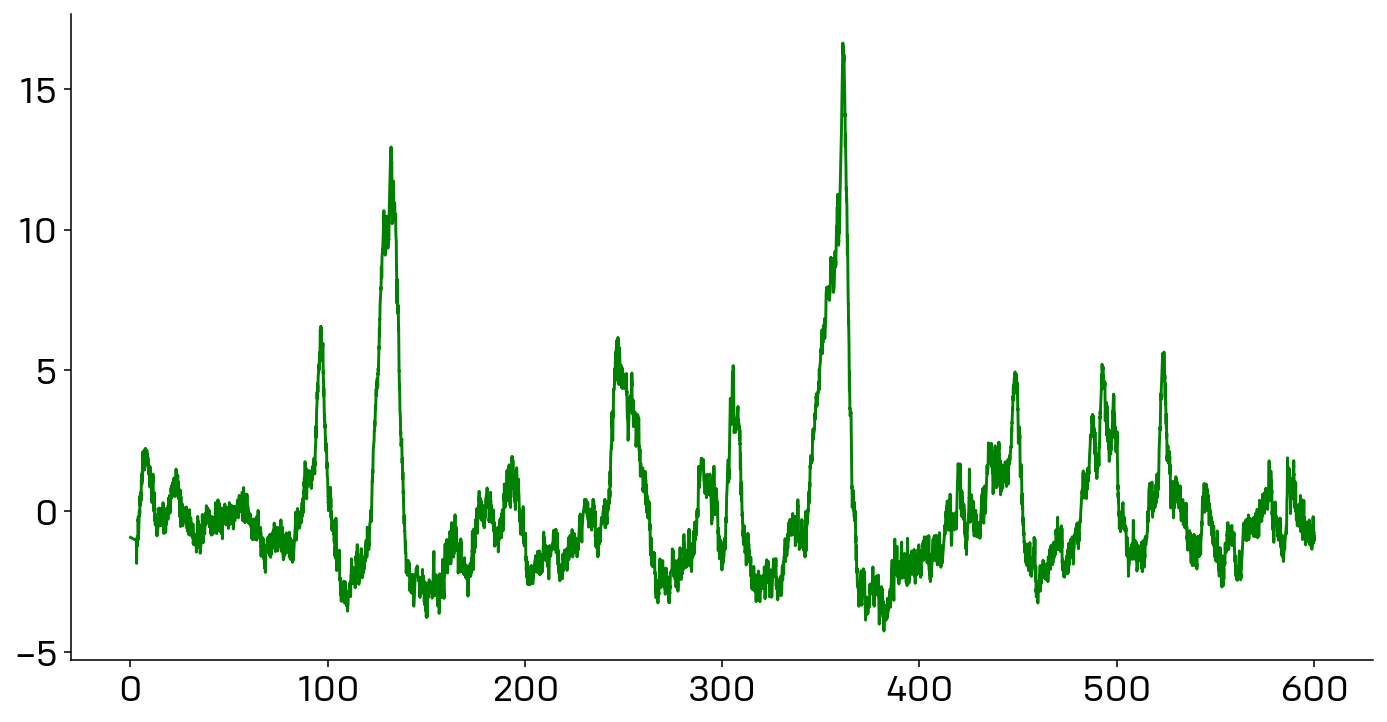

In [51]:
### NORMALIZATION : DF/F
dffg=100*gcamp_corrected/gcamp_expfit
dffr=100*rcamp_corrected/rcamp_expfit

plt.figure(figsize=(12, 6))
plt.plot(time, dffg, color='g')
#plt.plot(time, dffr, color='r')
# plt.plot(time, rcamp_est_motion, color='b')
# plt.xlim(250, 360)
#ax1.set_ylim(-3, 3)

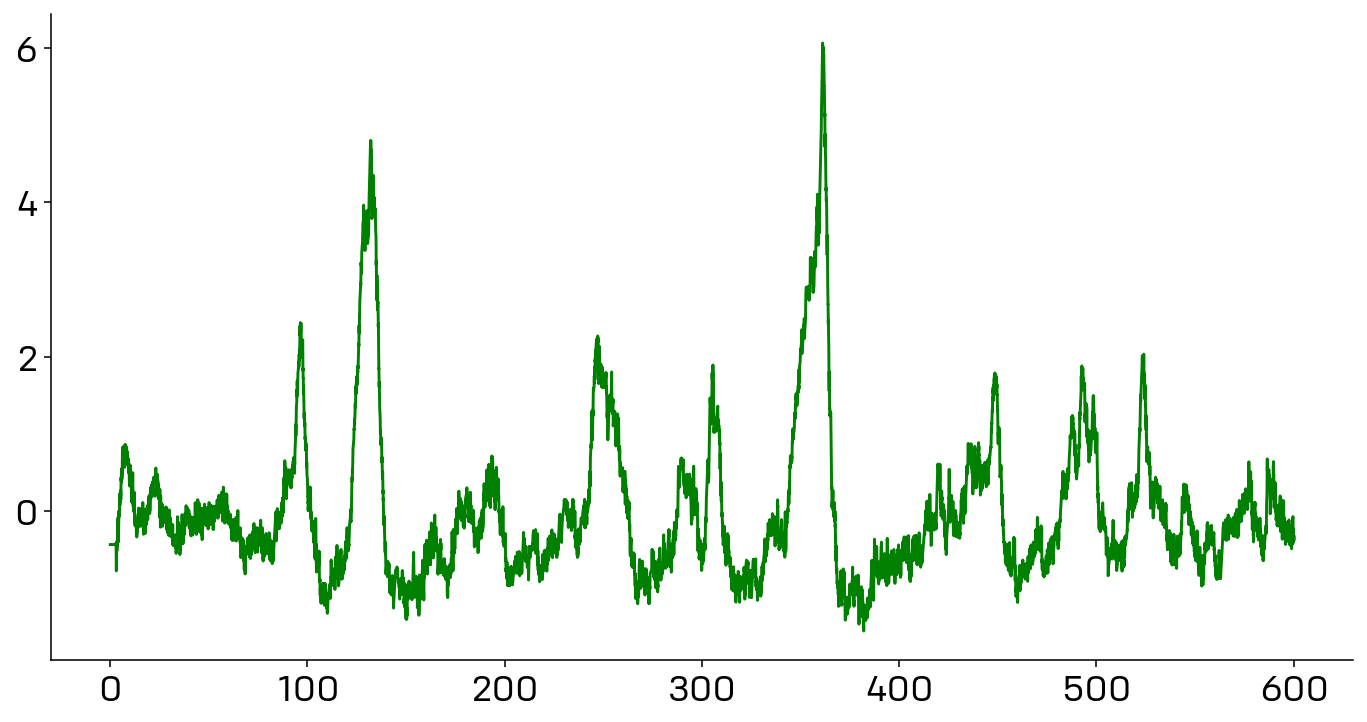

In [52]:
## Normalization : Z-Scoring 
zscoreg = (gcamp_corrected-np.mean(gcamp_corrected))/np.std(gcamp_corrected)
zscorer = (rcamp_corrected-np.mean(rcamp_corrected))/np.std(rcamp_corrected)

plt.figure(figsize=(12, 6))
plt.plot(time, zscoreg, color='g')
# plt.plot(time, zscorer, color='r')


#plt.xlim(450, 460)
#ax1.set_ylim(-3, 3);

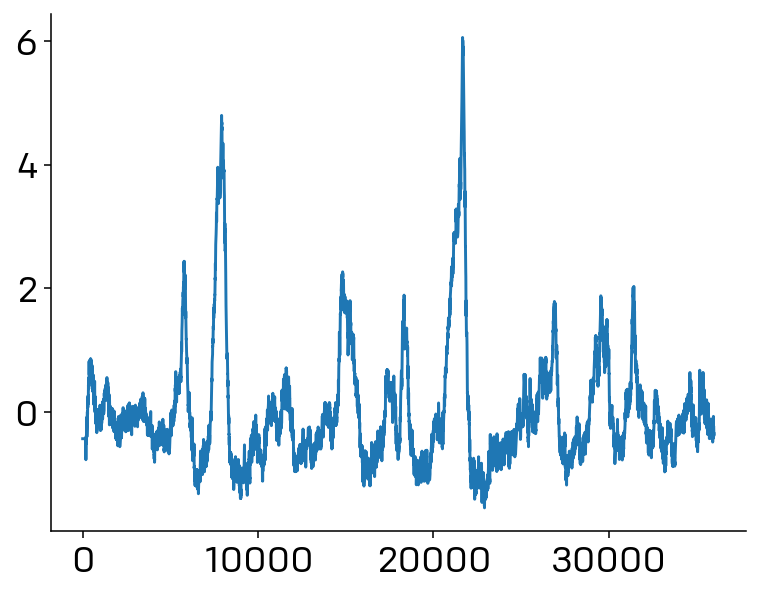

In [53]:
## SMOOTHING
from scipy.signal import savgol_filter


polyorder = 2  # Polynomial order
window_length = 181  # Window length: must be an odd number

# Apply the filter
zscore = savgol_filter(zscoreg, window_length, polyorder)

plt.plot(zscoreg)

In [54]:
###Convert preprocessed traces as df for easier manipulation

fp_df = pd.DataFrame({'Time': time, 'Zscoreg': zscoreg, 'Zscorer' : zscorer})
fp_df

,Time,Zscoreg,Zscorer
0,0.085739,-0.431547,-0.061754
1,0.102411,-0.431547,-0.061754
2,0.119084,-0.431547,-0.061754
3,0.135756,-0.431547,-0.061754
4,0.152428,-0.431547,-0.061754
...,...,...,...
35987,600.072826,-0.316037,-0.313524
35988,600.089499,-0.349317,0.270571
35989,600.106171,-0.381711,0.140160
35990,600.122843,-0.381265,-0.887667


In [55]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.ndimage import gaussian_filter

# # Drop rows with NaN values in 'Centre position X' and 'Centre position Y'
# ampos = ampos.dropna(subset=['Centre position X', 'Centre position Y'])

# # Define 10 cm bins for spatial positions
# bin_size = 10 # cm
# x_bins = np.arange(ampos['Centre position X'].min(), ampos['Centre position X'].max() + bin_size, bin_size)
# y_bins = np.arange(ampos['Centre position Y'].min(), ampos['Centre position Y'].max() + bin_size, bin_size)

# # Assign data to spatial bins
# ampos['X_bin'] = pd.cut(ampos['Centre position X'], bins=x_bins, labels=x_bins[:-1], include_lowest=True)
# ampos['Y_bin'] = pd.cut(ampos['Centre position Y'], bins=y_bins, labels=y_bins[:-1], include_lowest=True)

# # Merge the Zscoreg data back into ampos
# ampos = ampos.merge(binned_zscoreg, on='Time (s)', how='left')

# # Group by spatial bins and compute the mean Zscoreg
# spatial_avg = ampos.groupby(['X_bin', 'Y_bin'])['Zscoreg'].mean().reset_index()

# # Convert bins to numeric for heatmap plotting
# spatial_avg['X_bin'] = spatial_avg['X_bin'].astype(float)
# spatial_avg['Y_bin'] = spatial_avg['Y_bin'].astype(float)

# # Pivot the table to create a 2D array for the heatmap
# heatmap_data = spatial_avg.pivot(index='Y_bin', columns='X_bin', values='Zscoreg')

# # Apply Gaussian smoothing to the heatmap data
# smoothed_data = gaussian_filter(heatmap_data.fillna(0), sigma=1)

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(smoothed_data, cmap='inferno', cbar_kws={'label': 'Mean Zscoreg'})

# # Set heatmap properties
# plt.title('Smoothed Heatmap of Mean Zscoreg in Spatial Bins')
# plt.xlabel('X Position (cm)')
# plt.ylabel('Y Position (cm)')

# # # Set x and y limits
# # plt.xlim(0, 550)
# # plt.ylim(0, 550)

# plt.gca().invert_yaxis()  # Invert y-axis to match typical spatial representation
# plt.show()


In [56]:


#Create time bins and put them into main df
time_bins = ampos['Time (s)'].values  # Use ampos time as bin edges
time_bins = np.append(time_bins, time_bins[-1] + (time_bins[-1] - time_bins[-2]))  # Add an extra bin edge to cover all data
fp_df['Time_bin'] = pd.cut(fp_df['Time'], bins=time_bins, labels=time_bins[:-1], include_lowest=True)

# Average Zscore for each bin
binned_zscoreg = fp_df.groupby('Time_bin')['Zscoreg'].mean().reset_index()
binned_zscoreg.rename(columns={'Time_bin': 'Time (s)'}, inplace=True)

binned_zscoreg['Zscoreg'] = (binned_zscoreg['Zscoreg'] - binned_zscoreg['Zscoreg'].min()) / (binned_zscoreg['Zscoreg'].max() - binned_zscoreg['Zscoreg'].min())
ampos2 = ampos.merge(binned_zscoreg, on='Time (s)', how='left')
np.max(ampos2['Zscoreg'])

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_27663/1975995737.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_zscoreg = fp_df.groupby('Time_bin')['Zscoreg'].mean().reset_index()


1.0

      Time (s)  Centre position X  Centre position Y
1        0.344              174.0              196.0
2        0.616              203.0              196.0
3        0.744              207.0              195.0
4        0.888              215.0              196.0
5        1.016              224.0              198.0
...        ...                ...                ...
4460   599.352              130.0              211.0
4461   599.480              130.0              211.0
4462   599.624              131.0              211.0
4463   599.752              131.0              211.0
4464   599.880              131.0              211.0

[4464 rows x 3 columns]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_27663/2242337231.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spatial_avg = ampos2.groupby(['X_bin', 'Y_bin'])['Zscoreg'].mean().reset_index()


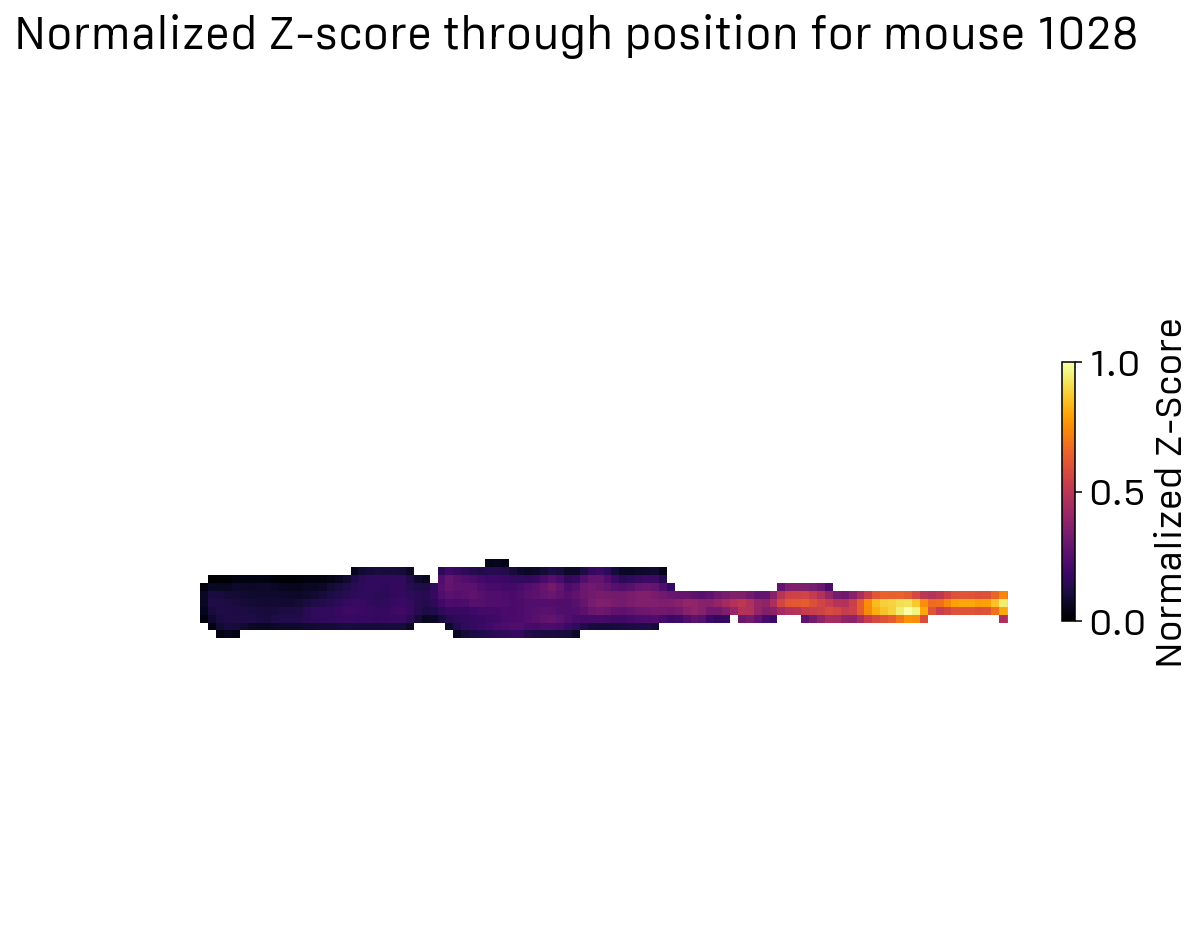

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.convolution import convolve, Gaussian2DKernel
from scipy.ndimage import gaussian_filter

# Create a copy to preserve the original dataset
ampos2 = ampos.copy()

# Drop rows with NaN values in 'Centre position X' and 'Centre position Y'
ampos2 = ampos2.dropna(subset=['Centre position X', 'Centre position Y'])
print(ampos2)

# Define 1 cm bins for spatial positions
bin_size = 5  # cm
x_bins = np.arange(0, 650, bin_size)
y_bins = np.arange(0, 650, bin_size)

# Assign data to spatial bins
ampos2['X_bin'] = pd.cut(ampos2['Centre position X'], bins=x_bins, labels=x_bins[:-1], include_lowest=True)
ampos2['Y_bin'] = pd.cut(ampos2['Centre position Y'], bins=y_bins, labels=y_bins[:-1], include_lowest=True)

# Merge the Zscoreg data back into ampos2
ampos2 = ampos2.merge(binned_zscoreg, on='Time (s)', how='left')

# Group by spatial bins and compute the mean Zscoreg
spatial_avg = ampos2.groupby(['X_bin', 'Y_bin'])['Zscoreg'].mean().reset_index()

# Convert bins to numeric for heatmap plotting
spatial_avg['X_bin'] = spatial_avg['X_bin'].astype(float)
spatial_avg['Y_bin'] = spatial_avg['Y_bin'].astype(float)

# Pivot the table to create a 2D array for the heatmap
heatmap_data = spatial_avg.pivot(index='Y_bin', columns='X_bin', values='Zscoreg')

# Fill missing values with NaN instead of 0
heatmap_data = heatmap_data.fillna(np.nan)

# Create Gaussian Kernel and apply smoothing
stddev = 0.3  # Standard deviation for the Gaussian kernel
kernel = Gaussian2DKernel(stddev)
smoothed_data = convolve(heatmap_data, kernel, boundary='extend')

# Mask NaN values
masked_data = np.nan_to_num(smoothed_data, nan=0)
mask = ~np.isnan(smoothed_data)

# Apply Gaussian filter only to the valid (non-NaN) data
smoothed_data = gaussian_filter(masked_data, sigma=1)
smoothed_data[~mask] = np.nan  # Restore NaN values


smoothed_data = (smoothed_data - np.nanmin(smoothed_data)) / (np.nanmax(smoothed_data) - np.nanmin(smoothed_data))

# Plot the smoothed heatmap

print(smoothed_data)

plt.figure(figsize=(10, 8))
plt.imshow(smoothed_data, cmap='inferno', extent=[0, 650, 0, 650], origin='lower', interpolation='none', zorder=3)

# Customize plot
cbar=plt.colorbar(label='Normalized Z-Score', shrink=0.3, fraction=0.05)
cbar.set_ticks([0, 0.5, 1])
plt.xlabel('Centre Position X (mm)')
plt.ylabel('Centre Position Y (mm)')
plt.title(f'Normalized Z-score through position for mouse {mouse_id}')
plt.xlim(0, 550) # Set background color to black
plt.ylim(0, 550)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)


#plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/smoothed_heatmap{mouse_id}.pdf', format='pdf')
plt.show()

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_27663/2237301388.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spatial_avg = ampos2.groupby(['X_bin', 'Y_bin'])['Zscoreg'].mean().reset_index()


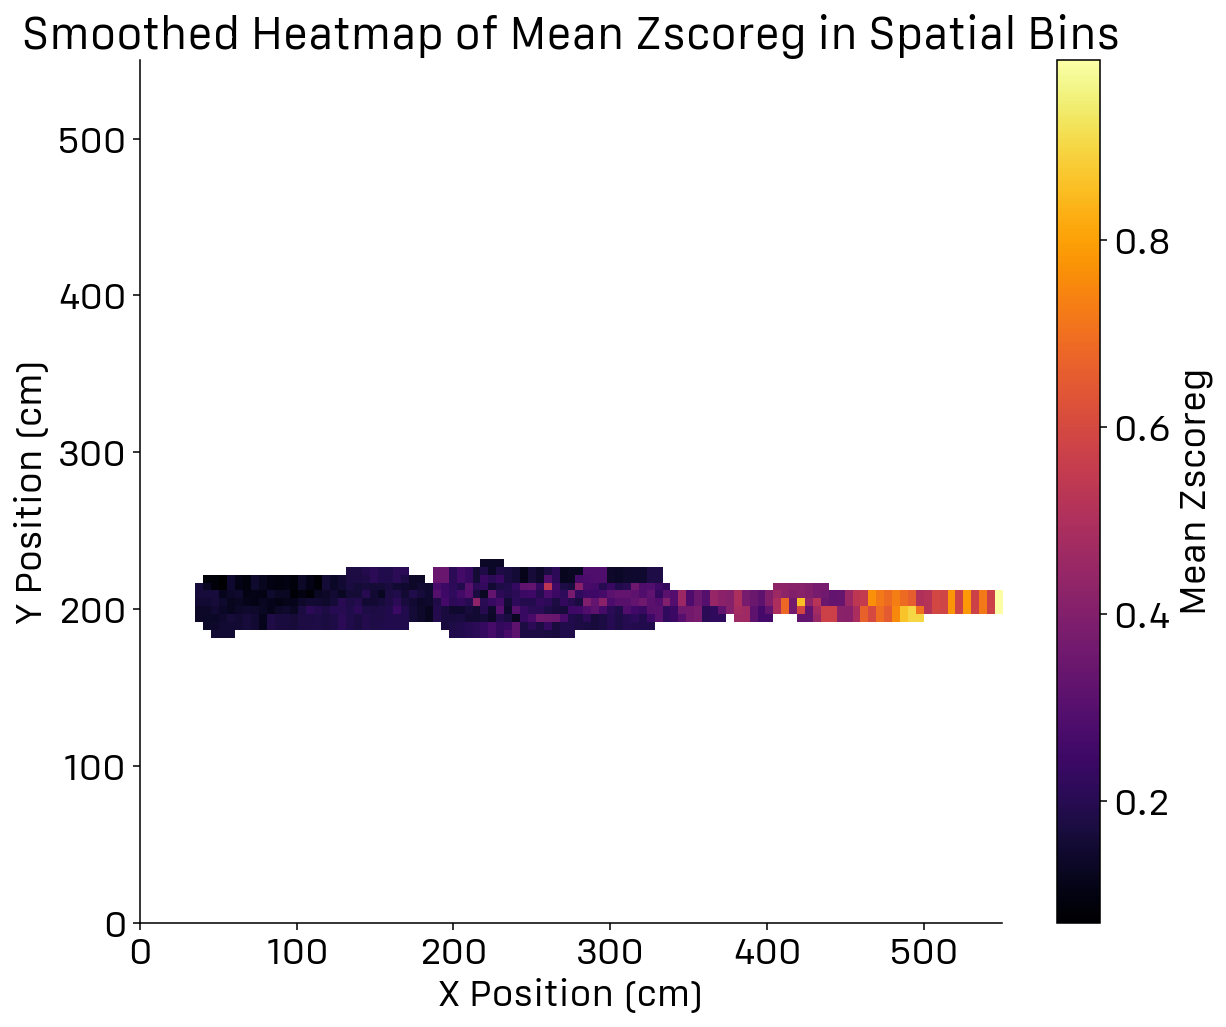

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.convolution import convolve, Gaussian2DKernel

# Create a copy to preserve the original dataset
ampos2 = ampos.copy()

# Drop rows with NaN values in 'Centre position X' and 'Centre position Y'
ampos2 = ampos2.dropna(subset=['Centre position X', 'Centre position Y'])

# Define 1 cm bins for spatial positions
bin_size = 5  # cm
x_bins = np.arange(0, 550, bin_size)
y_bins = np.arange(0, 550, bin_size)

# Assign data to spatial bins
ampos2['X_bin'] = pd.cut(ampos2['Centre position X'], bins=x_bins, labels=x_bins[:-1], include_lowest=True)
ampos2['Y_bin'] = pd.cut(ampos2['Centre position Y'], bins=y_bins, labels=y_bins[:-1], include_lowest=True)

# Merge the Zscoreg data back into ampos2
ampos2 = ampos2.merge(binned_zscoreg, on='Time (s)', how='left')

# Group by spatial bins and compute the mean Zscoreg
spatial_avg = ampos2.groupby(['X_bin', 'Y_bin'])['Zscoreg'].mean().reset_index()

# Convert bins to numeric for heatmap plotting
spatial_avg['X_bin'] = spatial_avg['X_bin'].astype(float)
spatial_avg['Y_bin'] = spatial_avg['Y_bin'].astype(float)

# Pivot the table to create a 2D array for the heatmap
heatmap_data = spatial_avg.pivot(index='Y_bin', columns='X_bin', values='Zscoreg')

# Fill missing values with NaN instead of 0
heatmap_data = heatmap_data.fillna(np.nan)

# Create Gaussian Kernel and apply smoothing
stddev = 0.2  # Standard deviation for the Gaussian kernel
kernel = Gaussian2DKernel(stddev)
smoothed_data = convolve(heatmap_data, kernel, boundary='extend')

# Normalize to preserve peak intensity
if np.nanmax(smoothed_data) > 0:  # Prevent division by zero
    smoothed_data *= np.nanmax(heatmap_data) / np.nanmax(smoothed_data)

# Plot the smoothed heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(smoothed_data, cmap='inferno', extent=[0, 550, 0, 550], origin='lower', interpolation='none')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Mean Zscoreg')

# Customize plot
ax.set_title('Smoothed Heatmap of Mean Zscoreg in Spatial Bins')
ax.set_xlabel('X Position (cm)')
ax.set_ylabel('Y Position (cm)')
ax.set_xlim(0, 550)
ax.set_ylim(0, 550)

plt.show()


Correlation between Zscoreg and Centre position X: 0.7710944705041382
P-value: 0.0


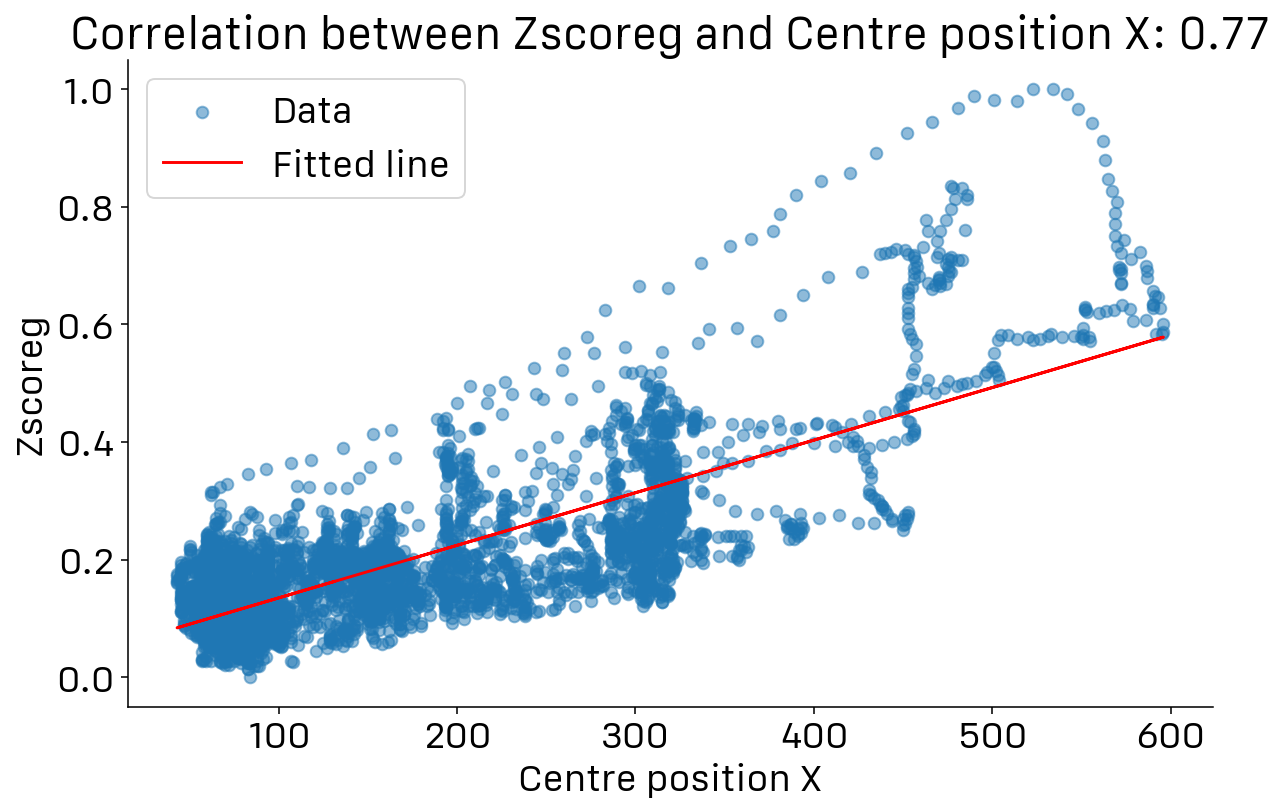

In [59]:
from scipy.stats import linregress

# Compute the correlation
correlation, p_value = ampos2['Zscoreg'].corr(ampos2['Centre position X']), linregress(ampos2['Centre position X'], ampos2['Zscoreg']).pvalue
print(f"Correlation between Zscoreg and Centre position X: {correlation}")
print(f"P-value: {p_value}")

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(ampos2['Centre position X'], ampos2['Zscoreg'])

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(ampos2['Centre position X'], ampos2['Zscoreg'], alpha=0.5, label='Data')
plt.plot(ampos2['Centre position X'], intercept + slope * ampos2['Centre position X'], color='red', label='Fitted line')
plt.xlabel('Centre position X')
plt.ylabel('Zscoreg')
plt.title(f'Correlation between Zscoreg and Centre position X: {correlation:.2f}')
plt.legend()
plt.show()

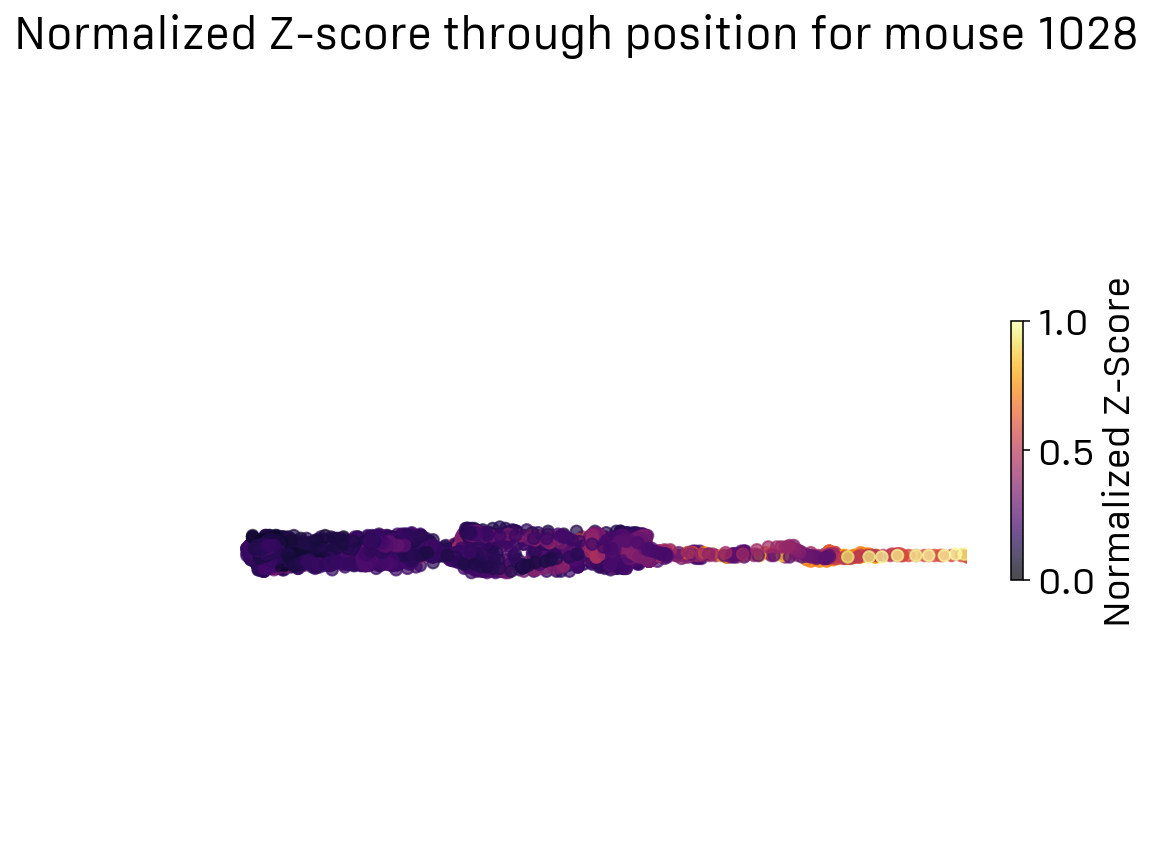

In [60]:
# plot the shit
plt.figure(figsize=(8, 8))

# Plot the scatter plot first
scatter = plt.scatter(
    ampos2['Centre position X'], 
    ampos2['Centre position Y'], 
    c=ampos2['Zscoreg'], 
    cmap='inferno',
    alpha=0.7,
    zorder=3)

# Now, plot the cross in the background by drawing after the scatter
cross_size = 420  # Size of the cross in mm
center_x = 295    # Center position X
center_y = 235   # Center position Y

# # Add the cross in the background (horizontal and vertical lines)
# plt.plot([center_x - cross_size / 2, center_x + cross_size / 2], [center_y, center_y], color='black', lw=22)  # horizontal line
# plt.plot([center_x, center_x], [center_y - cross_size / 2, center_y + cross_size / 2], color='black', lw=25)  # vertical line
# plt.plot([center_x - cross_size / 2, center_x + cross_size / 2], 
#          [center_y, center_y], color='white', lw=21, zorder=2)
# plt.plot([center_x, center_x], 
#          [center_y - cross_size / 2, center_y + cross_size / 2], 
#          color='white', lw=21, zorder=2)

plt.colorbar(scatter, label='Normalized Z-Score', shrink=0.3, fraction=0.05)
plt.xlabel('Centre Position X (mm)')
plt.ylabel('Centre Position Y (mm)')
plt.title(f'Normalized Z-score through position for mouse {mouse_id}')
plt.xlim(0, 550) # Set background color to black
plt.ylim(0, 550)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

In [61]:
# Initialize a dictionary to store events for each behavior
all_events = {col: {'start': [], 'end': []} for col in TTL_an.columns if col != 'Time (s)'}

# Function to extract start and end events for each behavior
def extract_events(TTL_an):
    for col in all_events.keys():
        sound_on = False
        start_time = None  # Initialize start_time
        
        for i in range(len(TTL_an)):
            if TTL_an[col].iloc[i] == 1:
                if not sound_on:  # Event starts
                    start_time = TTL_an['Time (s)'].iloc[i]
                    sound_on = True
            elif TTL_an[col].iloc[i] == 0:
                if sound_on:  # Event stops
                    end_time = TTL_an['Time (s)'].iloc[i]
                    all_events[col]['start'].append(start_time)
                    all_events[col]['end'].append(end_time)
                    sound_on = False

        # Handle the case where the signal ends with 1
        if sound_on:
            end_time = 600  # WORKS ONLY WITH THIS CONFIGURATION
            all_events[col]['start'].append(start_time)
            all_events[col]['end'].append(end_time)

# Run the function
extract_events(TTL_an)

# Convert each behavior's event data to DataFrames
df_events = {col: pd.DataFrame(data) for col, data in all_events.items()}

# Print each DataFrame for each behavior
for behavior, df in df_events.items():
    print(f"Events for {behavior}:")
    print(df)
    print("\n")


Events for In black:
      start      end
0     0.000    0.616
1     8.952   15.384
2    23.480   28.392
3    32.312   59.144
4    59.320   90.184
5    97.752  117.784
6   136.584  184.792
7   196.856  241.112
8   264.152  281.784
9   295.256  295.320
10  298.312  299.320
11  313.416  335.048
12  336.184  336.760
13  336.920  338.760
14  365.912  427.192
15  452.392  476.552
16  500.984  511.160
17  535.880  600.000


Events for In grey:
      start      end
0     0.616    8.952
1    15.384   18.952
2    21.480   23.480
3    28.392   32.312
4    59.144   59.320
5    90.184   97.752
6   117.784  124.152
7   135.384  136.584
8   184.792  196.856
9   241.112  264.152
10  281.784  295.256
11  295.320  298.312
12  299.320  313.416
13  335.048  336.184
14  336.760  336.920
15  338.760  346.680
16  363.256  365.912
17  427.192  440.280
18  448.984  452.392
19  476.552  500.984
20  511.160  528.120
21  528.312  528.856
22  528.888  535.880


Events for In white:
     start      end
0   18.952 

In [62]:
# Add behavior columns to the main DataFrame
for behavior, df in df_events.items():
    # Initialize the behavior column with zeros
    fp_df[behavior] = 0
    
    # Iterate through each start and end time for the behavior
    for start, end in zip(df['start'], df['end']):
        # Set the behavior column to 1 for rows within the start-end interval
        fp_df.loc[(fp_df['Time'] >= start) & (fp_df['Time'] <= end), behavior] = 1

fp_df = fp_df.drop(columns=['Time_bin'])

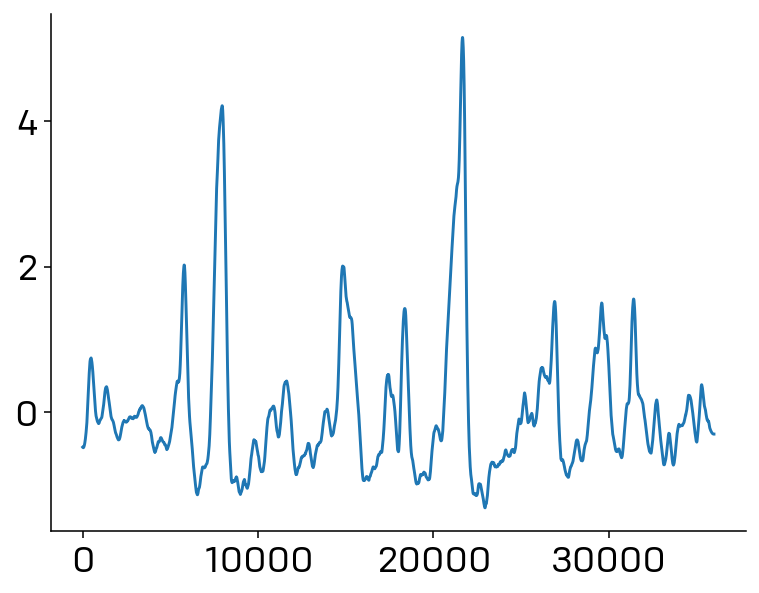

In [63]:
## SMOOTHING extreme smoothing for whole trace representative


polyorder = 2  # Polynomial order
window_length = 481  # Window length: must be an odd number

# Apply the filter
fp_df['Zscoreg'] = savgol_filter(fp_df['Zscoreg'], window_length, polyorder)

plt.plot(fp_df['Zscoreg'])

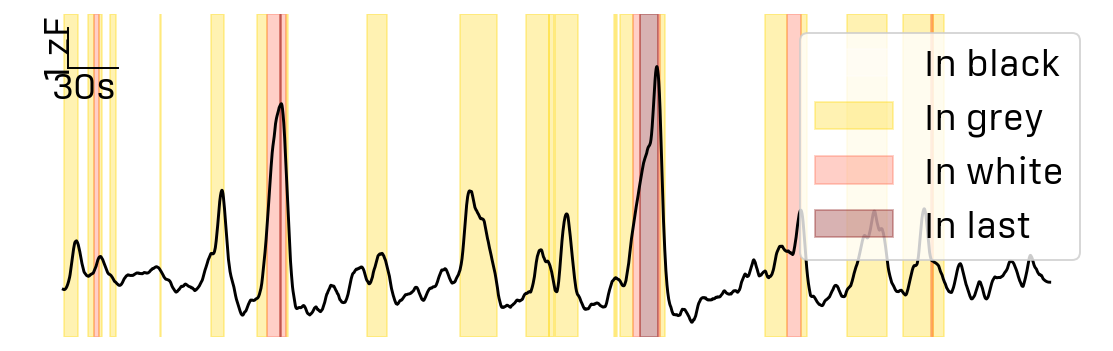

In [64]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create the plot
fig, ax = plt.subplots(figsize=(10, 3))

# Plot Zscoreg through Time
ax.plot(fp_df['Time'], fp_df['Zscoreg'], color='black')

# Define colors for events
behavior_columns = ['In black', 'In grey', 'In white', 'In last']
colors = ['white', 'gold', 'tomato', 'maroon']  # Use a colormap for unique colors

# Add shaded regions for each behavior
for color, behavior in zip(colors, behavior_columns):
    # Find time intervals where the behavior occurs
    starts = fp_df.loc[fp_df[behavior].diff() == 1, 'Time']
    ends = fp_df.loc[fp_df[behavior].diff() == -1, 'Time']
    
    # Handle case where behavior starts at the first row
    if not fp_df.empty and fp_df[behavior].iloc[0] == 1:
        starts = pd.concat([pd.Series(fp_df['Time'].iloc[0]), starts])
    # Handle case where behavior ends at the last row
    if not fp_df.empty and fp_df[behavior].iloc[-1] == 1:
        ends = pd.concat([ends, pd.Series(fp_df['Time'].iloc[-1])])
    
    # Add shaded regions with the assigned color
    for start, end in zip(starts, ends):
        ax.axvspan(start, end, alpha=0.3, label=behavior, color=color)

# Customize the plot

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

y_min, y_max = plt.gca().get_ylim()  # Get current y-axis limits
x_min, x_max = plt.gca().get_xlim()  # Get current x-axis limits
scale_x_pos = x_min + (x_max - x_min) * 0.05  # Position to the left of the plot
scale_y_pos = y_max - (y_max - y_min) * 0.05  # Position near the top of the plot

plt.plot([scale_x_pos, scale_x_pos], [scale_y_pos, scale_y_pos + 1], color='black', linewidth=1)
plt.text(scale_x_pos - 5, scale_y_pos + 0.5, '1 zF', ha='center', va='center', rotation='vertical')

plt.plot([scale_x_pos, scale_x_pos + 30], [scale_y_pos, scale_y_pos], color='black', linewidth=1)  # Horizontal line at y=0
plt.text(scale_x_pos + 10, scale_y_pos - 0.1, '30s', ha='center', va='top')

#drop the y axis
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)
#Create one legend entry per event
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates
ax.legend(by_label.values(), by_label.keys(), loc='upper right')
# plt.xlim(200,400)
# plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/figures/fullrecording{mouse_id}.pdf', format='pdf')
plt.show()

In [65]:
#add mouse ID, sex and day of experiment(if needed)

fp_df['ID']=mouse_id
fp_df['sex']=sex
fp_df

,Time,Zscoreg,Zscorer,In black,In grey,In white,In last,ID,sex
0,0.085739,-0.484142,-0.061754,1,0,0,0,1028,M
1,0.102411,-0.484609,-0.061754,1,0,0,0,1028,M
2,0.119084,-0.485060,-0.061754,1,0,0,0,1028,M
3,0.135756,-0.485495,-0.061754,1,0,0,0,1028,M
4,0.152428,-0.485914,-0.061754,1,0,0,0,1028,M
...,...,...,...,...,...,...,...,...,...
35987,600.072826,-0.304217,-0.313524,0,0,0,0,1028,M
35988,600.089499,-0.304190,0.270571,0,0,0,0,1028,M
35989,600.106171,-0.304159,0.140160,0,0,0,0,1028,M
35990,600.122843,-0.304126,-0.887667,0,0,0,0,1028,M


In [66]:
# #saving the processed df with timestamps and zscoreeees 

# new_filename = f'{mouse_id}_{sex}_preprocessed.csv'  
# save_folder='/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/preprocessed'
# save_path = os.path.join(save_folder, new_filename)

# fp_df.to_csv(save_path, index=False)